In [1]:
import numpy as np

from statespace.models import BrownianConstantVelocityModel, NVMConstantVelocityModel, BrownianLangevinModel, NVMLangevinModel

from stochastic.processes import GammaProcess, TemperedStableProcess, GeneralisedInverseGaussianProcess

from statespace.methods import KalmanFilter, SequentialCollapsedGaussianMCMCFilter

import pandas as pd
import matplotlib.pyplot as plt

# Langevin model example:

In [2]:
N = 50
D = 2
D_prime = 1
n_particles = 1

times = np.linspace(start=0, stop=1, num=N).reshape(N, 1)

##################################
# Initial distribution definition.
##################################

x_init = np.random.normal(loc=0., scale=0.1, size=(D, 1))
#x_init = np.random.normal(loc=0., scale=0.1, size=(n_particles, D, 1))

##################################
# State transition dynamics.
##################################

theta = -0.5
mu = 0.
sigma = 1.0
# subordinator = GammaProcess(**{"beta":1., "C":1.})
# subordinator = TemperedStableProcess(**{"alpha":0.6, "beta":0.1, "C":0.5})
subordinator = GeneralisedInverseGaussianProcess(**{"lam":-0.8, "gamma":0.01, "delta":1.0})

##################################
# Observation model.
##################################

sigma_eps = 0.00001

##################################
# Langevin model.
##################################

model = NVMLangevinModel(**{"subordinator":subordinator, "theta":theta, "mu":mu, "sigma":sigma, "sigma_eps":sigma_eps})

Residual approximation mode is set to Gaussian approximation.
Simulation method is set to improved version.
Residual approximation method is set to lower bounding method.
Residual approximation mode is set to Gaussian approximation.
Residual approximation mode is set to Gaussian approximation.


In [3]:
X, Y, t_series, x_series = model.sample(times, x_init, n_particles=n_particles)

/Users/yaman/models/stochastic/processes.py:38: RuntimeWarning: overflow encountered in exp
  return 1/(self.beta*(np.exp(gamma/self.C)-1))
/Users/yaman/models/stochastic/processes.py:739: RuntimeWarning: invalid value encountered in divide
  envelope_fnc = (((2*self.delta**2)**self.abs_lam)*incgammal(self.abs_lam, (z1**2)*x_series/(2*self.delta**2))*self.abs_lam*(1+self.abs_lam)
/Users/yaman/models/stochastic/processes.py:744: RuntimeWarning: divide by zero encountered in divide
  z_series = np.sqrt(((2*self.delta**2)/x_series)*gammaincinv(self.abs_lam, u_z*gammainc(self.abs_lam, (z1**2)*x_series/(2*self.delta**2))))
/Users/yaman/models/stochastic/processes.py:744: RuntimeWarning: invalid value encountered in multiply
  z_series = np.sqrt(((2*self.delta**2)/x_series)*gammaincinv(self.abs_lam, u_z*gammainc(self.abs_lam, (z1**2)*x_series/(2*self.delta**2))))
/Users/yaman/models/stochastic/processes.py:754: RuntimeWarning: invalid value encountered in divide
  envelope_fnc = (((2*self.de

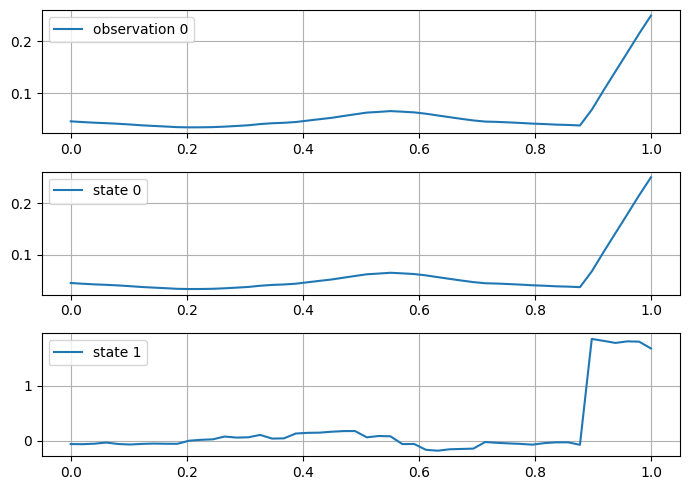

In [4]:
fig, ax = plt.subplots(nrows=(X.shape[-2] + Y.shape[-2]), ncols=n_particles, figsize=(7,5))

if (n_particles > 1):

    for particle_idx in range(n_particles):
        i = 0

        for j in range(Y.shape[-2]):
            ax[i][particle_idx].plot(times, Y[:,particle_idx, j,:], label=f'observation {j}')
            ax[i][particle_idx].grid(True)
            ax[i][particle_idx].legend()
            i += 1

        for j in range(X.shape[-2]):
            ax[i][particle_idx].plot(times, X[:,particle_idx, j,:], label=f'state {j}')
            ax[i][particle_idx].grid(True)
            ax[i][particle_idx].legend()
            i += 1

else:
    for particle_idx in range(n_particles):
        i = 0

        for j in range(Y.shape[-2]):
            ax[i].plot(times, Y[:,particle_idx, j,:], label=f'observation {j}')
            ax[i].grid(True)
            ax[i].legend()
            i += 1

        for j in range(X.shape[-2]):
            ax[i].plot(times, X[:,particle_idx, j,:], label=f'state {j}')
            ax[i].grid(True)
            ax[i].legend()
            i += 1

plt.tight_layout()
plt.show()

In [9]:
y_axis_lims = [-1., 2.5]

## Kalman filtering:

In [10]:
##################################
# Initial distribution definition.
##################################

x_init_gaussian = np.random.normal(loc=0., scale=0.1, size=(D, 1))
# x_init = np.random.normal(loc=0., scale=1., size=(n_particles, D, 1))

C_init_gaussian = 1*np.eye(D)

##################################
# State transition dynamics.
##################################

theta_gaussian = theta
sigma_gaussian = sigma

##################################
# Observation model.
##################################

sigma_eps_gaussian = sigma_eps

##################################
# Langevin model.
##################################

model_gaussian = BrownianLangevinModel(**{"theta":theta_gaussian, "sigma":sigma_gaussian, "sigma_eps":sigma_eps_gaussian})

observations = Y[:,0,:]
inference_module_gaussian = KalmanFilter(model=model_gaussian, prior=None, proposal=None)

The prior configuration is not valid.


In [11]:
memory_gaussian = inference_module_gaussian.filter(times, observations, x_init_gaussian, C_init_gaussian)

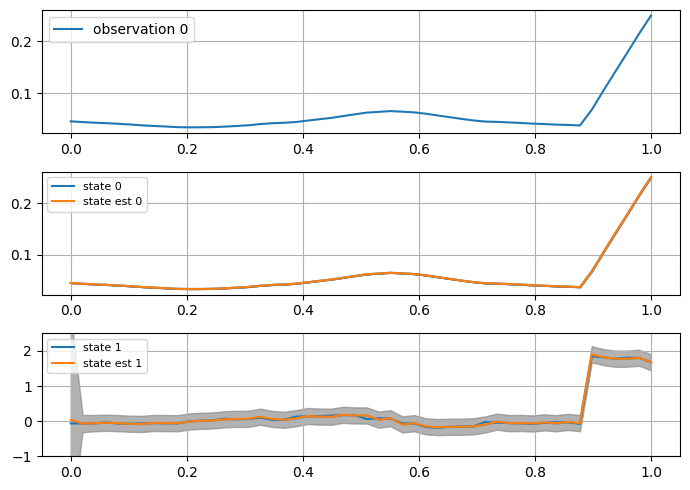

In [12]:
fig, ax = plt.subplots(nrows=(X.shape[-2] + Y.shape[-2]), ncols=n_particles, figsize=(7,5))

if (n_particles > 1):

    for particle_idx in range(n_particles):
        i = 0

        for j in range(Y.shape[-2]):
            ax[i][particle_idx].plot(times, Y[:,particle_idx, j,:], label=f'observation {j}')
            ax[i][particle_idx].grid(True)
            ax[i][particle_idx].legend()
            i += 1

        for j in range(X.shape[-2]):
            ax[i][particle_idx].plot(times, X[:,particle_idx, j,:], label=f'state {j}')
            ax[i][particle_idx].plot(times, memory_gaussian['filtered_mean'][:,j,:], label=f'state est {j}')
            ax[i][particle_idx].fill_between(times.flatten(), memory_gaussian['filtered_mean'][:,j,:].flatten(), memory_gaussian['filtered_mean'][:,j,:].flatten() + 3 * np.sqrt(memory_gaussian['filtered_cov'][:,0,0]), alpha=0.6, color='grey')
            ax[i][particle_idx].fill_between(times.flatten(), memory_gaussian['filtered_mean'][:,j,:].flatten(), memory_gaussian['filtered_mean'][:,j,:].flatten() - 3 * np.sqrt(memory_gaussian['filtered_cov'][:,0,0]), alpha=0.6, color='grey')
            ax[i][particle_idx].grid(True)
            ax[i][particle_idx].legend()
            i += 1

else:
    for particle_idx in range(n_particles):
        i = 0

        for j in range(Y.shape[-2]):
            ax[i].plot(times, Y[:,particle_idx, j,:], label=f'observation {j}')
            ax[i].grid(True)
            ax[i].legend()
            i += 1

        for j in range(X.shape[-2]):
            ax[i].plot(times, X[:,particle_idx, j,:], label=f'state {j}')

            ax[i].plot(times, memory_gaussian['filtered_mean'][:,j,:], label=f'state est {j}')
            ax[i].fill_between(times.flatten(), memory_gaussian['filtered_mean'][:,j,:].flatten(), memory_gaussian['filtered_mean'][:,j,:].flatten() + 3 * np.sqrt(memory_gaussian['filtered_cov'][:,j,j]), alpha=0.6, color='grey')
            ax[i].fill_between(times.flatten(), memory_gaussian['filtered_mean'][:,j,:].flatten(), memory_gaussian['filtered_mean'][:,j,:].flatten() - 3 * np.sqrt(memory_gaussian['filtered_cov'][:,j,j]), alpha=0.6, color='grey')

            if (j == 1):
                ax[i].set_ylim(y_axis_lims[0], y_axis_lims[1])

            ax[i].grid(True)
            ax[i].legend(fontsize=8)
            i += 1

plt.tight_layout()
plt.show()

## Sequential Collapsed Gaussian MCMC:

In [13]:
##################################
# Initial distribution definition.
##################################

x_init_levy = np.random.normal(loc=0., scale=0.1, size=(D, 1))
# x_init = np.random.normal(loc=0., scale=1., size=(n_particles, D, 1))

C_init_levy = np.random.normal(loc=0., scale=0.1, size=(D, D))
C_init_levy = C_init_levy.T @ C_init_levy

##################################
# State transition dynamics.
##################################

theta_levy = theta
mu_levy = mu
sigma_levy = sigma

# subordinator = GammaProcess(**{"beta":1., "C":1.})
# subordinator = TemperedStableProcess(**{"alpha":0.6, "beta":0.1, "C":0.5})
subordinator_levy = GeneralisedInverseGaussianProcess(**{"lam":-0.8, "gamma":0.01, "delta":1.0})

##################################
# Observation model.
##################################

sigma_eps_levy = sigma_eps

##################################
# Langevin model.
##################################

model_levy = NVMLangevinModel(**{"subordinator":subordinator_levy, "theta":theta_levy, "mu":mu_levy, "sigma":sigma_levy, "sigma_eps":sigma_eps_levy})

observations = Y[:,0,:]
inference_module = SequentialCollapsedGaussianMCMCFilter(model=model_levy, prior=None, proposal=None)

Residual approximation mode is set to Gaussian approximation.
Simulation method is set to improved version.
Residual approximation method is set to lower bounding method.
Residual approximation mode is set to Gaussian approximation.
Residual approximation mode is set to Gaussian approximation.
The prior configuration is not valid.


In [14]:
memory, chain = inference_module.filter(times, observations, x_init_levy, C_init_levy, n_samples=50, burn_in=0)

/Users/yaman/models/statespace/methods.py:181: RuntimeWarning: overflow encountered in exp
  likelihood_ratio = np.exp(log_marginal_likelihood[0,0,0] - chain['log_conditional_likelihood'][-1][0, 0, 0])


0.8298564118660083


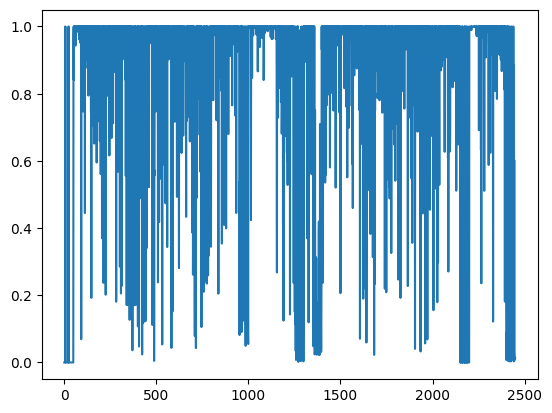

In [15]:
print(np.array(inference_module.acceptance_rates).mean())
plt.plot(np.array(inference_module.acceptance_rates));

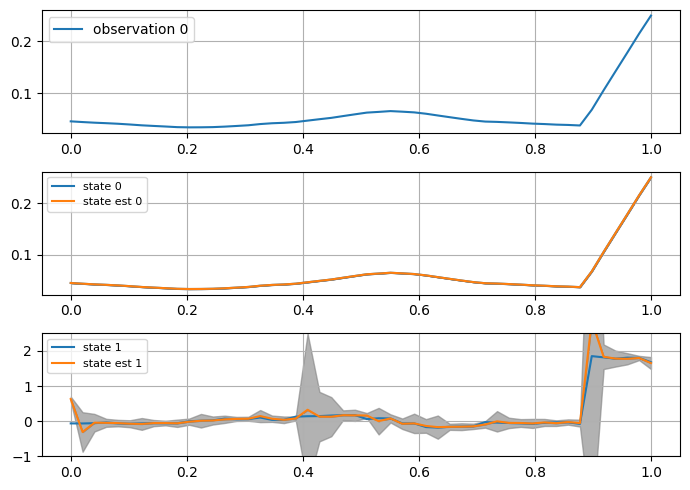

In [16]:
fig, ax = plt.subplots(nrows=(X.shape[-2] + Y.shape[-2]), ncols=n_particles, figsize=(7,5))

if (n_particles > 1):

    for particle_idx in range(n_particles):
        i = 0

        for j in range(Y.shape[-2]):
            ax[i][particle_idx].plot(times, Y[:,particle_idx, j,:], label=f'observation {j}')
            ax[i][particle_idx].grid(True)
            ax[i][particle_idx].legend()
            i += 1

        for j in range(X.shape[-2]):
            ax[i][particle_idx].plot(times, X[:,particle_idx, j,:], label=f'state {j}')
            ax[i][particle_idx].plot(times, memory['filtered_mean'][:,j,:], label=f'state est {j}')
            ax[i][particle_idx].fill_between(times.flatten(), memory['filtered_mean'][:,j,:].flatten(), memory['filtered_mean'][:,j,:].flatten() + 3 * np.sqrt(memory['filtered_cov'][:,0,0]), alpha=0.6, color='grey')
            ax[i][particle_idx].fill_between(times.flatten(), memory['filtered_mean'][:,j,:].flatten(), memory['filtered_mean'][:,j,:].flatten() - 3 * np.sqrt(memory['filtered_cov'][:,0,0]), alpha=0.6, color='grey')
            ax[i][particle_idx].grid(True)
            ax[i][particle_idx].legend()
            i += 1

else:
    for particle_idx in range(n_particles):
        i = 0

        for j in range(Y.shape[-2]):
            ax[i].plot(times, Y[:,particle_idx, j,:], label=f'observation {j}')
            ax[i].grid(True)
            ax[i].legend()
            i += 1

        for j in range(X.shape[-2]):
            ax[i].plot(times, X[:,particle_idx, j,:], label=f'state {j}')

            ax[i].plot(times, memory['filtered_mean'][:,j,:], label=f'state est {j}')
            ax[i].fill_between(times.flatten(), memory['filtered_mean'][:,j,:].flatten(), memory['filtered_mean'][:,j,:].flatten() + 3 * np.sqrt(memory['filtered_cov'][:,j,j]), alpha=0.6, color='grey')
            ax[i].fill_between(times.flatten(), memory['filtered_mean'][:,j,:].flatten(), memory['filtered_mean'][:,j,:].flatten() - 3 * np.sqrt(memory['filtered_cov'][:,j,j]), alpha=0.6, color='grey')

            if (j == 1):
                ax[i].set_ylim(y_axis_lims[0], y_axis_lims[1])

            ax[i].grid(True)
            ax[i].legend(fontsize=8)
            i += 1

plt.tight_layout()
plt.show()